<a href="https://colab.research.google.com/github/imonM007/InfraCrackNet/blob/main/InfraCrackNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InfraCrackNet Codes

This code processes a labeled dataset of infrastructure images to detect cracks. The annotations are generated using makesense.ai and converted into mask images with OpenCV, where cracks are represented as white pixels on a black background. The U-Net model is implemented for image segmentation, trained over 20 epochs using the Adam optimizer and sparse categorical cross-entropy loss. The model achieves over 98% accuracy, and the code outputs predictions, comparing true and predicted crack masks for evaluation.


## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

## Data

### Load dataset from TFDS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# input directory
label_files = glob.glob("/content/drive/MyDrive/Dataset/label/*.jpg")
np.random.shuffle(label_files)

In [ ]:
# counting files
print("Number of label files: {}".format(len(label_files)))
def image_exists(label_file):
  image_path = label_file.replace("/label/", "/image/")
  return os.path.exists(image_path)
label_files = list(filter(image_exists, label_files))
print("Number of label files that have corresponding image files: {}".format(len(label_files)))

Number of label files: 4874
Number of label files that have corresponding image files: 4174


In [ ]:
# spliting dataset
BATCH_SIZE = 64
BUFFER_SIZE = len(label_files)
VALIDATION_SIZE = int(len(label_files) * 0.1)
TEST_SIZE = int(len(label_files) * 0.2) - VALIDATION_SIZE
TRAIN_SIZE = len(label_files) - VALIDATION_SIZE - TEST_SIZE

print("Dataset size: {}, Train size: {}, test size: {}, validation size: {}".format(len(label_files), TRAIN_SIZE, TEST_SIZE, VALIDATION_SIZE))

Dataset size: 4174, Train size: 3340, test size: 417, validation size: 417


In [ ]:
train_labels, test_labels = train_test_split(label_files, test_size=0.2, shuffle=False)

Take a look at the dataset info. Note the `test` and `train` data split is already built in the dataset.

In [ ]:
def tf_data_generator(file_list):
  i = 0
  for label_file_path in file_list:
    label_file_path = label_file_path.decode("utf-8")
    image_path = label_file_path.replace("/label/", "/image/")
    if os.path.exists(image_path):
      image = np.asarray(Image.open(image_path))

      label = Image.open(label_file_path)
      label = label.convert('L')
      label = np.asarray(label).astype(int)
      label = np.expand_dims(label, axis=2)
      i = i + 1
      label[label <= 128] = 0
      label[label > 128] = 1
      yield image, label

train_dataset = tf.data.Dataset.from_generator(tf_data_generator, args=[train_labels], output_types=(tf.float32, tf.uint8), output_shapes=((227,227,3),(227,227,1)))
test_dataset = tf.data.Dataset.from_generator(tf_data_generator, args=[test_labels], output_types=(tf.float32, tf.uint8), output_shapes=((227,227,3),(227,227,1)))

### Data preprocessing

In [ ]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask



In [ ]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    # input_mask -= 1

    return input_image, input_mask

In [ ]:
def load_image_train(input_image, input_mask):
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
def load_image_test(input_image, input_mask):
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
print(train_dataset)

<_FlatMapDataset element_spec=(TensorSpec(shape=(227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(227, 227, 1), dtype=tf.uint8, name=None))>


Create train, validation and test batches. Note we split the original `test_dataset` into validation and test batches.

In [ ]:
train_batches = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE).take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_batches = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE).skip(VALIDATION_SIZE).take(TEST_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>


### Data Visualization

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

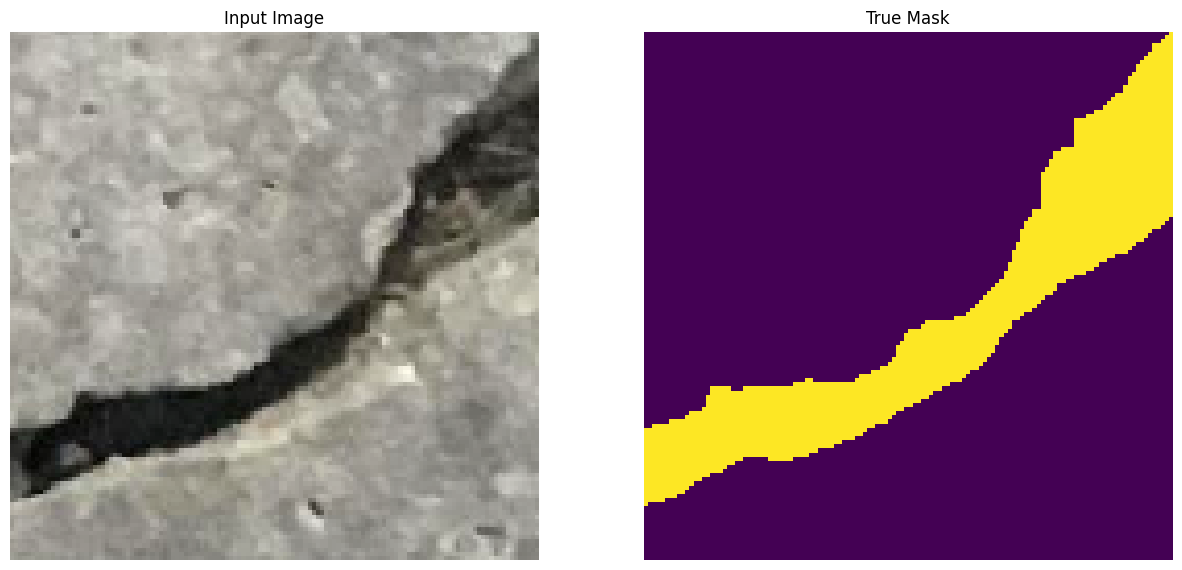

In [ ]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
np.unique(sample_mask.numpy())

array([0, 1], dtype=uint8)

## U-Net Building blocks
Create the building blocks for making the components U-Net model.

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

## Build the U-Net Model

In [ ]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64, 64, 64)     │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 16, 16, 256)    │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 8, 8, 512)      │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 8, 8, 512)      │              0 │ max_pooling2d_7[0][0]  │
├──────────────────────

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# tf.keras.utils.plot_model(unet_model, show_shapes=True)

## Compile and Train U-Net

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics=['accuracy'])

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = TRAIN_SIZE
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_batches = train_batches.repeat()
validation_batches = validation_batches.repeat()

VAL_SUBSPLITS = 5
TEST_LENTH = VALIDATION_SIZE
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 836ms/step - accuracy: 0.9768 - loss: 0.0599 - val_accuracy: 0.9683 - val_loss: 0.0894
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 840ms/step - accuracy: 0.9772 - loss: 0.0589 - val_accuracy: 0.9805 - val_loss: 0.0485
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 823ms/step - accuracy: 0.9785 - loss: 0.0552 - val_accuracy: 0.9753 - val_loss: 0.0686
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 824ms/step - accuracy: 0.9781 - loss: 0.0555 - val_accuracy: 0.9728 - val_loss: 0.0837
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 823ms/step - accuracy: 0.9782 - loss: 0.0559 - val_accuracy: 0.9789 - val_loss: 0.0530
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 823ms/step - accuracy: 0.9786 - loss: 0.0551 - val_accuracy: 0.9784 - val_loss: 0.0570
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 822ms/step - accuracy: 0.9795 - loss: 0.0521 - val_accuracy: 0.9777 - val_loss: 0.0542
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 823ms/step - accuracy: 0.9793 - loss: 0.0517 - val_accu

## Learning curve from model history

In [ ]:
def display_learning_curves(history):
  print(history.history)
  acc = history.history["accuracy"]
  # val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  # val_loss = history.history["val_loss"]

  epochs_range = range(NUM_EPOCHS)

  fig = plt.figure(figsize=(12,6))

  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, label="train accuracy")
  # plt.plot(epochs_range, val_acc, label="validataion accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")

  plt.subplot(1,2,2)
  plt.plot(epochs_range, loss, label="train loss")
  # plt.plot(epochs_range, val_loss, label="validataion loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

  fig.tight_layout()
  plt.show()

{'accuracy': [0.9773800373077393, 0.9774051308631897, 0.978648841381073, 0.9780553579330444, 0.9784626960754395, 0.9784532785415649, 0.9796955585479736, 0.9794730544090271, 0.9802522659301758, 0.9810967445373535, 0.9811697602272034, 0.9810615181922913, 0.9814636707305908, 0.9820606112480164, 0.9819015860557556, 0.9824463129043579, 0.9813573360443115, 0.9804472327232361, 0.9817500114440918, 0.9788008332252502], 'loss': [0.058454230427742004, 0.05832832306623459, 0.054800763726234436, 0.056359462440013885, 0.055114489048719406, 0.0556960292160511, 0.05149657279253006, 0.051646143198013306, 0.050397004932165146, 0.04773251712322235, 0.04760948196053505, 0.04665883257985115, 0.04600157588720322, 0.04350987449288368, 0.04401714727282524, 0.042086776345968246, 0.04527822881937027, 0.04863077774643898, 0.04421441629528999, 0.05634647607803345], 'val_accuracy': [0.9683351516723633, 0.9804515838623047, 0.9753074645996094, 0.9727716445922852, 0.9788999557495117, 0.9784307479858398, 0.97772771120

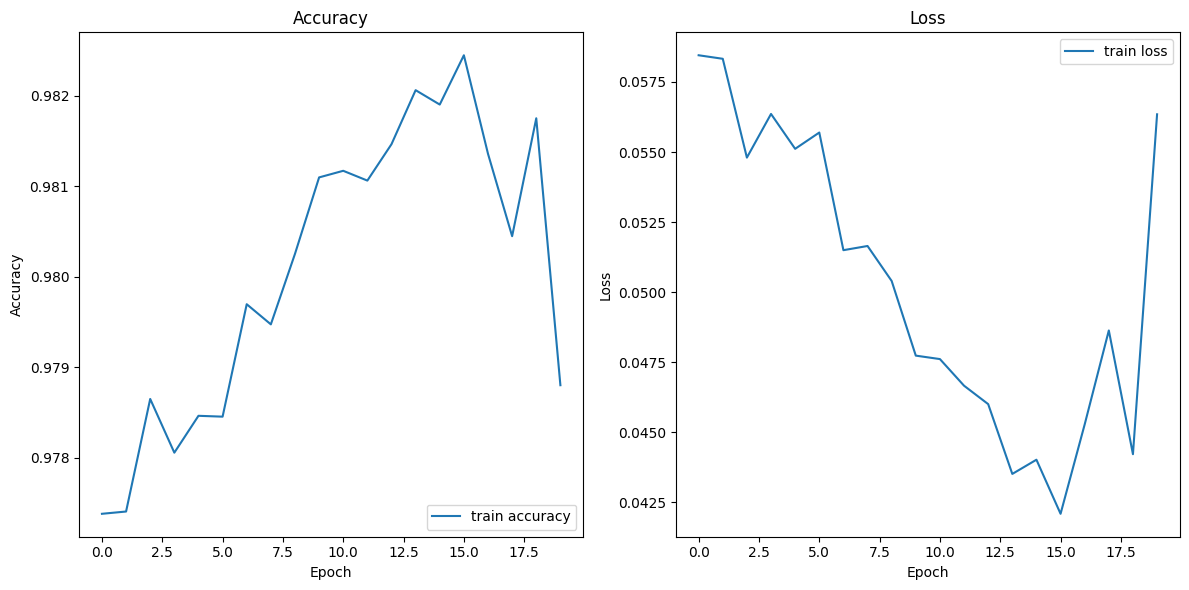

In [ ]:
# Display learning curves
display_learning_curves(unet_model.history)

## Predictions with U-Net model
Let's try the trained U-Net model on a few samples from the test dataset.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset, num=1):
  if dataset:
    for image, mask in dataset.take(num):

      # temporary part
      # print(image.size)

      pred_mask = unet_model.predict(image)
      for i in range(num):
        display([image[i], mask[i], pred_mask[i]])

In [ ]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 7


2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step


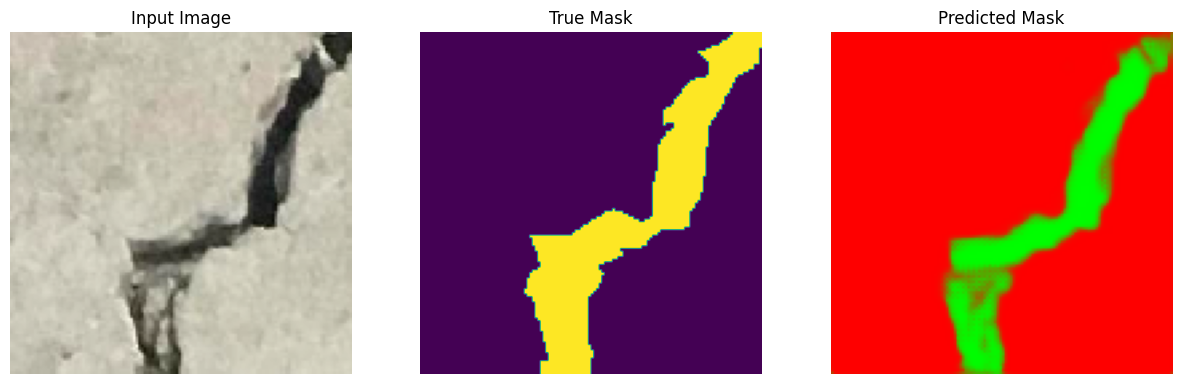

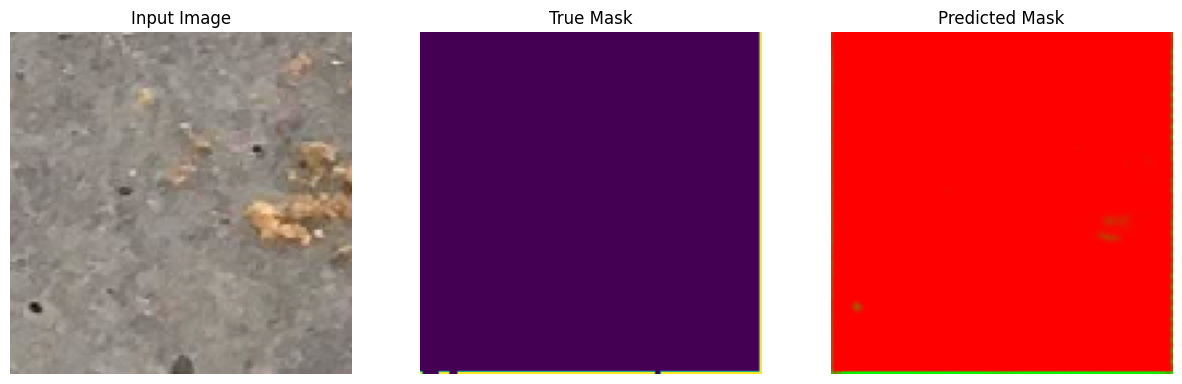

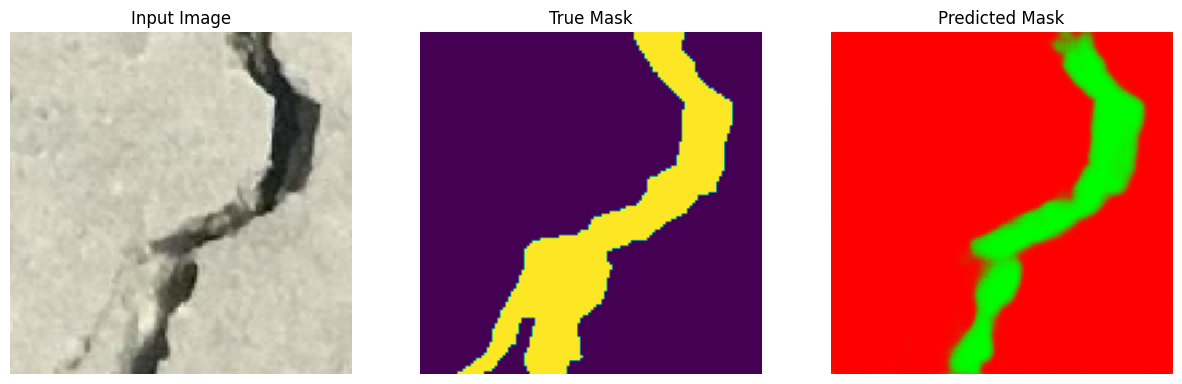

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


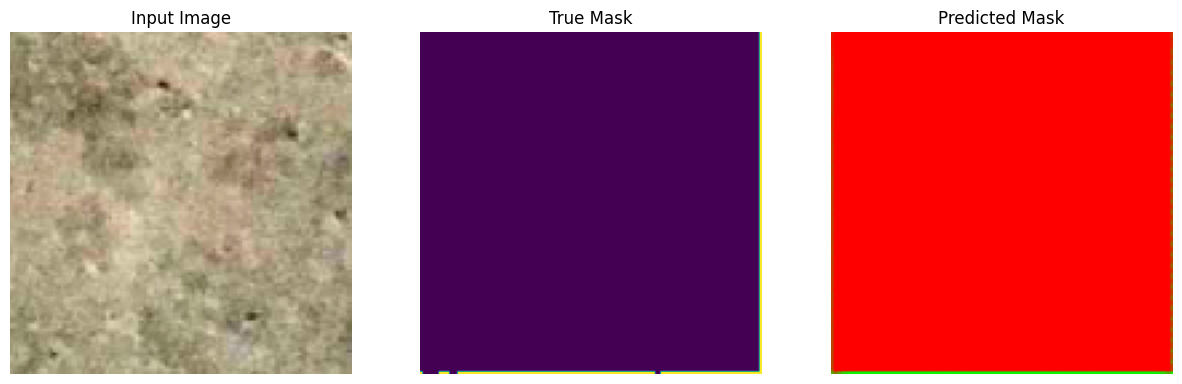

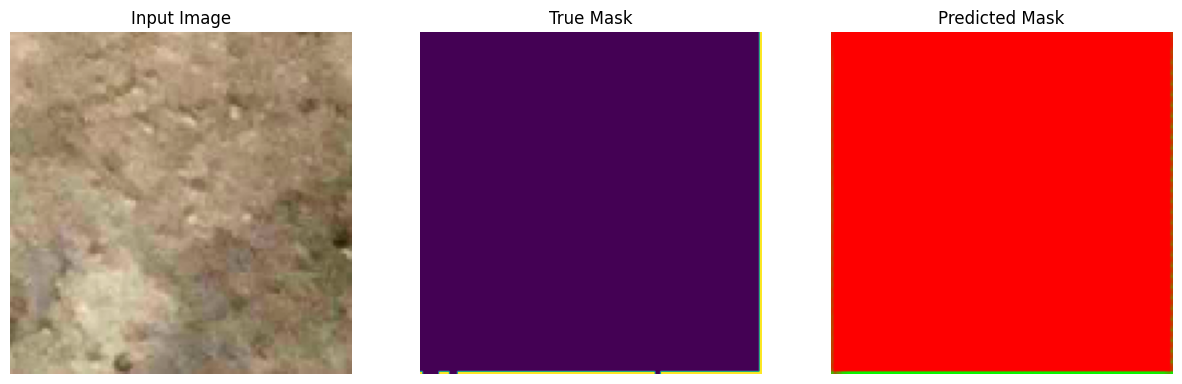

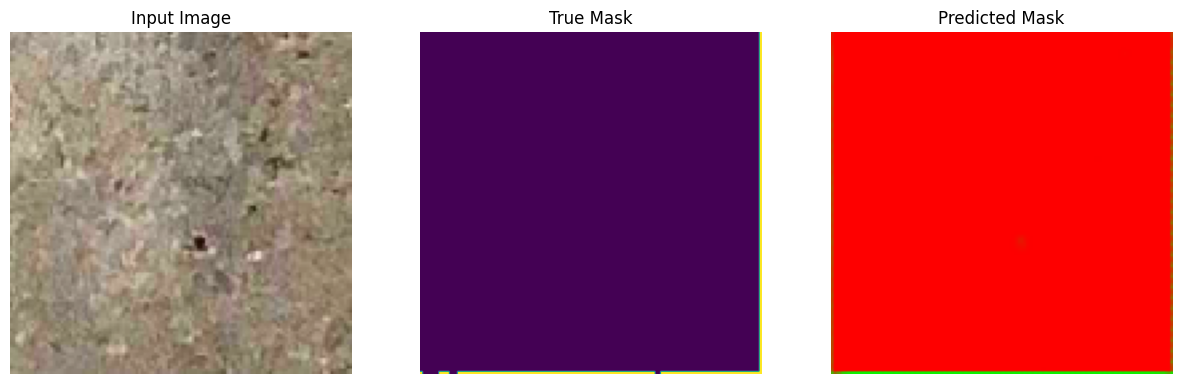

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


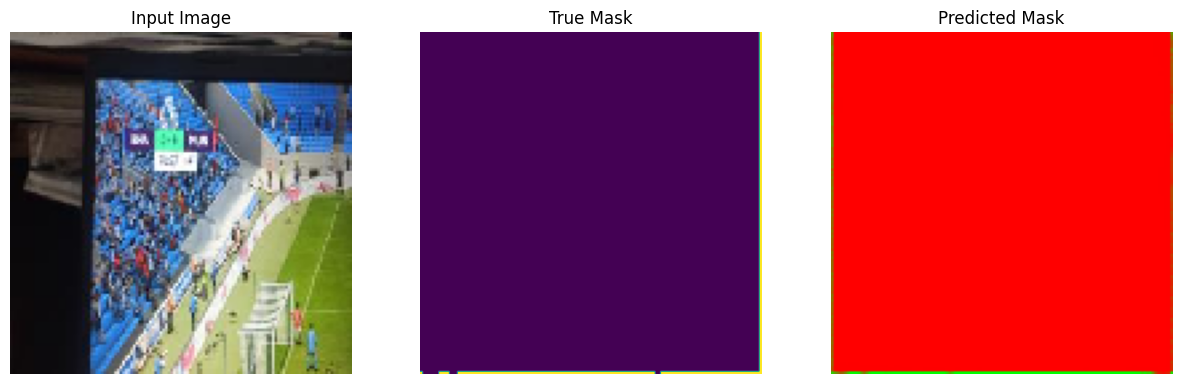

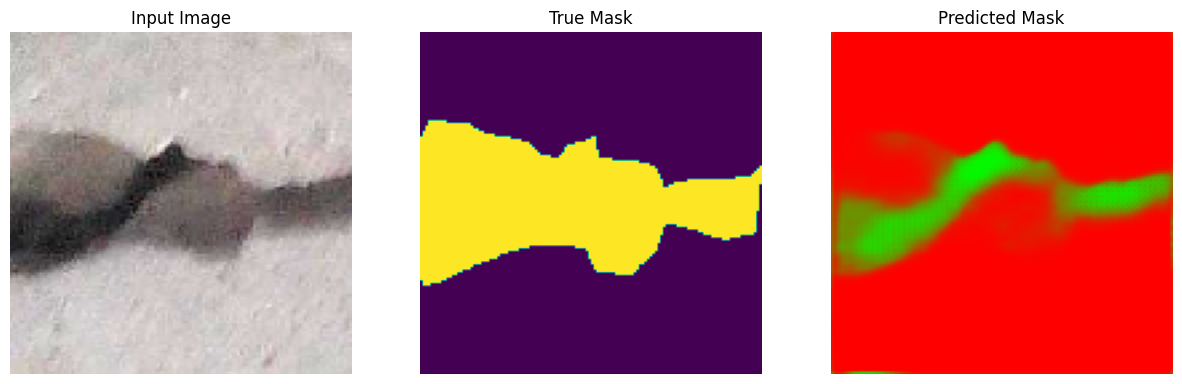

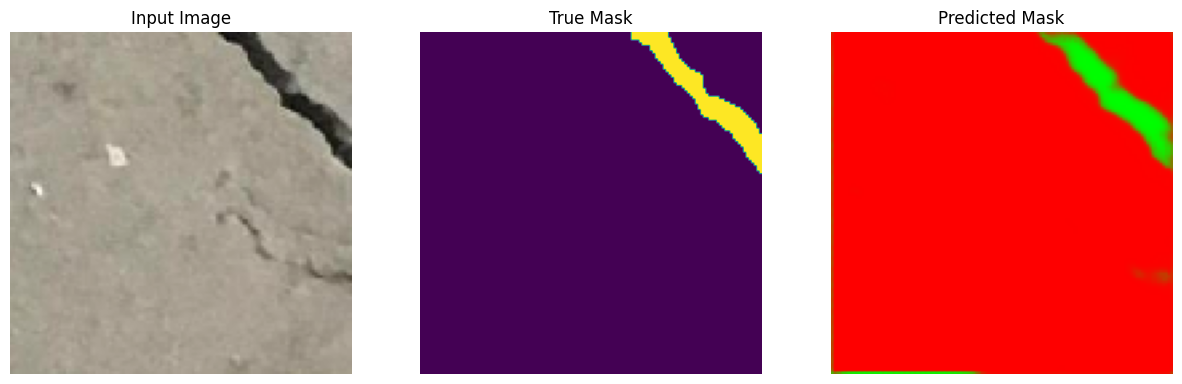

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
# keras
unet_model.save("/content/drive/MyDrive/Colab Notebooks/trained_model_2.keras")

#  .h5 extension
unet_model.save("/content/drive/MyDrive/Colab Notebooks/trained_model_2.h5")